# Statistiques

Aux chapitres précédents, nous avons vu comment organiser et manipuler des tableaux de données, puis les visualiser. La statistique est une collection de disciplines liées à la collecte, l'oragnisation, l'analyse, l'interprétation et la présentation de données. Les biostatistiques est l'application de ces disciplines à la biosphère.

Les statistiques consistent à "faire du sens" (anglicisme assumé) avec des observations: collecter des échantillons, transformer les données, effectuer des tests,  analyser les résultats, les interpréter et les visualiser. Bien que ces tâches soient complexes, en particulier en ce qui a trait aux tests statistiques, la plupart des opérations statistiques peuvent être effectuées sans l'assistance de statisticien.ne.s. Les erreurs d'interprétation statistiques sont néanmoins courantes et la consultation de spécialistes n'est souvent pas un luxe.

Dans ce chapitre, nous verrons comment répondre correctement à une question valide et adéquate impliquant des données, avec l'aide d'outils de calcul scientifique. Nous couvrirons les notions de bases des distributions et des variables aléatoires qui nous permettront d'effectuer des tests statistiques commun avec Python (fréquentiel et bayésien). Nous couvrirons aussi les erreurs communément commises en recherche académique et les moyens simples deles éviter.

Nous aurons besoin des modules suivants.

- Modules scientifiques de base: `numpy`, `scipy` et `pandas`
- Modules graphiques: `matplotlib` et `seaborn`
- Modules de calcul statistique: [`statsmodels`](http://www.statsmodels.org), [`pymc3`](http://docs.pymc.io/) et [`bambi`](https://github.com/bambinos/bambi).

Mais débuttons par un exemple classique tiré d'une [conférence de Jake Vanderplas](https://www.youtube.com/watch?v=Iq9DzN6mvYA).

## Pile ou face?

Lorsque l'on lance une pièce de monnaie, le résultat est soi pile, soit face. Si la pièce n'est pas biaisée, la probabilité d'obtenir l'un ou l'autre de ces résultats est égale. `numpy` comprend des algorithmes pour générer des nombres aléatoires selon des distributions. Dans le cas d'un jeu de hasard à deux possibilités, on parle d'une distribution biomiale et on utilise la fonction `np.random.binomial`. En ajoutant un if-else ainsi qu'une fonction graphique, on peut construire un petit jeu.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

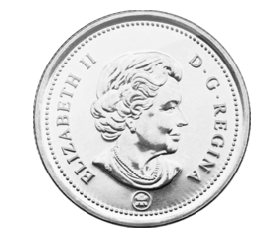

In [33]:
import matplotlib.image as mpimg

pf_result = np.random.binomial(n=1, p=0.5)
if pf_result == 0:
    plt.imshow(mpimg.imread('images/canada-25-cent-back.png'))
else:
    plt.imshow(mpimg.imread('images/canada-25-cent-front.png'))
plt.axis('off');

Mise en situation: Schtroumpfette ou vous devez payer un sac de chip au gagnant à un jeu de pile ou face où la pèce est lancée 25 fois. Vous choisissez pile, elle choisi face. La fonction `np.random.binomial` retourne le nombre de 1 (pile). Quant à la fonction `np.random.seed`, elle assume que la sortie de la fonction aléatoire sera toujours la même (pour les fins de l'exemple).

In [68]:
np.random.seed(seed=184008)
pf_result = np.random.binomial(n=25, p=0.5)
pf_result

19

Fantastique, vous avez 19 lancés à votre faveur: vous vous pressez de commissionner Schtroumpfette au dépanneur pour un sac de chips aux baies schtroumpfantes. Mais Schtroumpfette n'est pas d'accord. Un tel résultat ne peut être engendré que par une pièce biaisée.

Vous pourriez examiner la distribution de la masse dans la pièce: ce serait une approche mécanistique laborieuse. Vous préférez examiner les résultats en posant la question: la pièce est-elle biaisée?

Schtroumpfette est ferrée en stats. Pas vous. Mais vous maîtrisez bien Python. Vous modélisez un grand nombre de jeux de 25 lancés que vous savez non-biaisés (vous avez confiance en `numpy`), puis vous calculez la proportion de ces lancés qui donnent 19 piles ou plus. Comme ceci.

In [92]:
more_than_19 = 0
n_sim = 100000
for i in range(n_sim):
    pf_result = np.random.binomial(n=25, p=0.5)
    if pf_result >= 19:
        more_than_19 = more_than_19 + 1

print("La proportion des", n_sim, 
      "simulations ayant obtenu 19 piles ou plus est de",
      more_than_19/n_sim * 100, "%")

La proportion des 100000 simulations ayant obtenu 19 piles ou plus est de 0.754 %


Schtroumpfette y va plutôt de manière analytique.

...

## Poser la bonne question

La conception d'une expérience commence par une question. Ce chapitre est destinées à la statistique appliquée: il ne comprend pas la phase de conception expérimentale, une discipline a part entière. Les principes d'expérimentation sont plutôt présentés dans le cours [*Dispositifs expérimentaux (BVG-7002)*](https://www.ulaval.ca/les-etudes/cours/repertoire/detailsCours/bvg-7002-dispositifs-experimentaux.html). Également, je recommande le livre *Princpes d'expérimentation: planification des expériences et analyse de leurs résultats* de Pierre Dagnelie (2012), [disponible en ligne en format PDF](http://www.dagnelie.be/docpdf/ex2012.pdf).

- Quels sont les variables et leurs types
- Quels effets désire-t-on évaluer, de quel type de variable s'agit-il


## Les probabilités
> « Nous sommes si éloignés de connaître tous les agens de la nature, et leurs divers modes d'action ; qu'il ne serait pas philosophique de nier les phénomènes, uniquement parce qu'ils sont inexplicables dans l'état actuel de nos connaissances. Seulement, nous devons les examiner avec une attention d'autant plus scrupuleuse, qu'il paraît plus difficile de les admettre ; et c'est ici que le calcul des probabilités devient indispensable, pour déterminer jusqu'à quel point il faut multiplier les observations ou les expériences, afin d'obtenir en faveur des agens qu'elles indiquent, une probabilité supérieure aux raisons que l'on peut avoir d'ailleurs, de ne pas les admettre. » — Pierre-Simon de Laplace

### Interprétations fréquentistes et bayésiennes des probabilités

Qu'est-ce qu'une probabilité? Que signifie une probabilité de 0.5 de gagner à un jeu de pile ou face? Deux types d'interprétation se dégagent. L'interprétation **fréquentiste** représente la fréquence des occurences après un nombre infini d'événements. Par exemple, si vous jouez à pile ou face un grand nombre de fois, le nombre de pile sera égal à la moitié du nombre de lancés. Il s'agit de l'interprétation communément utilisée.

L'interprétation **bayésienne** vise à quantifier l'incertitude des phénomènes. Dans cette perspective, plus l'information s'accumule, plus l'incertitude diminue. Cette approche gagne en notoriété notamment parce qu'elle permet de décrire des phénomènes qui, intrinsèquement, ne peuvent être répétés infiniments (absence d'asymptote), comme celles qui sont bien définis dans le temps ou sur des populations limités.

Cette section comprend les deux interprétations.

### La théorie des probabilités

Une probabilité est la vraissemblance qu'un événements se réalise. Les probabilités forment le cadre des systèmes stochastiques, c'est-à-dire des systèmes trop complexes pour en connaître exactement les aboutissants, auxquels ont attribue une part de hasard. Ces systèmes sont prédominants dans les processus vivants.

#### Règles des probabilités

L'**Union** (p. 29)

#### Probabilités sur des variables discrètes

Une variable discrète prend la forme de variables catégorielles ou booléennes ou de nombres entiers. La variable booléenne pluie peut prendre la valeur 0 (faux) ou 1 (vrai). La probabilité que l'événement $A$ survienne est $p(A)$. Si $A$ se réfère à l'occurence ou non événement de pluie dans une journée, $p(A)$ est la probabilité de pluie, projetée dans le domaine de 0 (aucune chance qu'il pleuve) à 1 (il pleuvera définitivement) inclusivement. La variable $A$ est dite aléatoire si elle est générée par un processus stochastique. Quant à $p()$, c'est la fonction de masse, dont la somme de toutes les possibilités est toujours de 1.


## Les distributions


### Normale / Student
### Uniforme
### Binomiale
### Poisson
### Exponentielle
### Beta


## Tests statistiques

### Variance, covariance et corrélation

### Test de t

### Modélisation linéaire
- dummification des facteurs et matrices de concept
- Régression linéaire (lmplot, residplot)
- Anova sens unique
- Anova double sens

### Analyse de covariance
### Box M test
### Modélisation multi-niveau


## Erreurs communes

### Un résultat montrant une p-value plus élevée que 0.05 n'est pas pertinent

Lors d'une conférence, Dr Evil ne présentent que les résultats significatifs de ses essais au seuil de 0.05. Certains essais ne sont pas significatifs, mais bon, ceux-ci ne sont pas importants... En écartant ces résultats, Dr Evil commet 3 erreurs:

1. La p-value n'est pas un bon indicateur de l'importance d'un test statistique. L'importance d'une variable dans un modèle linéaire devrait être évaluée par la valeur de son coefficient. Son incertitude devrait être évaluée par sa variance. Une manière d'évaluer plus intuitive la variance est l'écart-type ou l'intervalle de confiance. À un certain seuil d'intervalle de confiance, la p-value traduira la probabilité qu'un coefficient soit réellement nul ait pu générer des données démontrant un coefficient égal ou supérieur.
2. Il est tout aussi important de savoir que le traitement fonctionne que de savoir qu'il ne fonctionne pas. Les résultats démontrant des effets sont malheureusement davantage soumis aux journaux et davantage publiés que ceux ne démontrant pas d'effets ([Decullier et al., 2005]( https://doi.org/10.1136/bmj.38488.385995.8F )).
3. Le seuil de 0.05 est arbitraire.

